In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

initial_cash = 10000
max_allocation = 0.8
future_window = 5
risk_level = 'medium'
ticker = 'XOM'
start_date = '2010-01-01'
end_date = '2025-01-01'

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
df.dropna(inplace=True)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [2]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['Momentum'] = df['Close'].diff(periods=10)
df['STD_20'] = df['Close'].rolling(window=20).std()
df['Upper_BB'] = df['SMA_10'] + 2 * df['STD_20']
df['Lower_BB'] = df['SMA_10'] - 2 * df['STD_20']
df['RSI'] = 100 - (100 / (1 + df['Close'].diff().clip(lower=0).rolling(14).mean() /
                            df['Close'].diff().clip(upper=0).abs().rolling(14).mean()))

df['Future_Return'] = df['Close'].shift(-future_window) / df['Close'] - 1

In [3]:
if risk_level == 'low':
    buy_threshold = 0.04
    sell_threshold = -0.04
elif risk_level == 'medium':
    buy_threshold = 0.02
    sell_threshold = -0.02
else:
    buy_threshold = 0.01
    sell_threshold = -0.01

conditions = [
    df['Future_Return'] > buy_threshold,
    df['Future_Return'] < sell_threshold
]
choices = [1, -1]
df['Signal'] = np.select(conditions, choices, default=0)

In [6]:
def backtest_strategy(df):
    cash = initial_cash
    position = 0
    portfolio_values = []

    for index, row in df.iterrows():
        signal = int(row['Signal'].item())
        price = row['Close'].item()

        if signal == 1 and position == 0:
            if price > 0:
                shares_to_buy = (cash * max_allocation) // price
                position = shares_to_buy
                cash -= shares_to_buy * price
            else:
                shares_to_buy = 0

        elif signal == -1 and position == 0:
            if price > 0:
                shares_to_short = (cash * max_allocation) // price
                position = -shares_to_short
                cash += shares_to_short * price
            else:
                shares_to_short = 0

        elif signal == 0 and position != 0:
            cash += position * price
            position = 0

        portfolio_values.append(cash + position * price)

    df['Portfolio_Value'] = portfolio_values
    return df

df = backtest_strategy(df)


Sharpe Ratio: 4.54


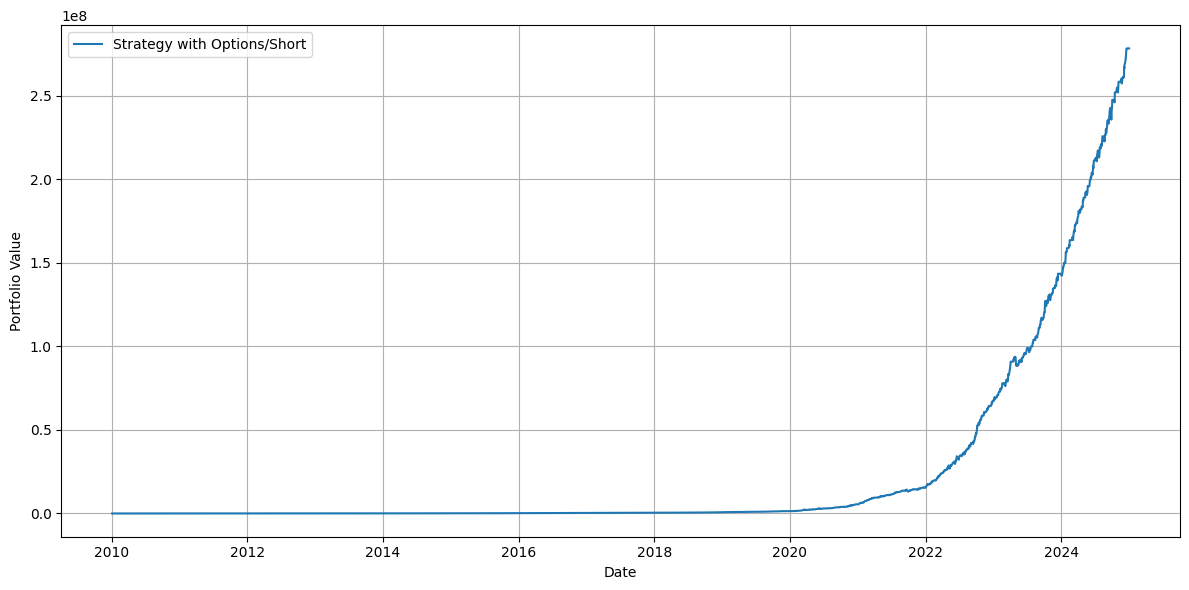

In [7]:
returns = df['Portfolio_Value'].pct_change().dropna()
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
print("\nSharpe Ratio:", round(sharpe_ratio, 2))

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Portfolio_Value'], label='Strategy with Options/Short')
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

initial_cash = 10000
max_allocation = 0.8
future_window = 5
risk_level = 'medium'
ticker = 'XOM'
start_date = '2010-01-01'
end_date = '2025-01-01'

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
df.dropna(inplace=True)
df.reset_index(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [9]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['Momentum'] = df['Close'].diff(periods=10)
df['STD_20'] = df['Close'].rolling(window=20).std()
df['Upper_BB'] = df['SMA_10'] + 2 * df['STD_20']
df['Lower_BB'] = df['SMA_10'] - 2 * df['STD_20']
df['RSI'] = 100 - (100 / (1 + df['Close'].diff().clip(lower=0).rolling(14).mean() /
                            df['Close'].diff().clip(upper=0).abs().rolling(14).mean()))

df['Future_Return'] = df['Close'].shift(-future_window) / df['Close'] - 1

def get_thresholds(risk):
    return {
        'low': (0.04, -0.04),
        'medium': (0.02, -0.02),
        'high': (0.01, -0.01)
    }[risk]

buy_th, sell_th = get_thresholds(risk_level)
df['Signal'] = np.select(
    [df['Future_Return'] > buy_th, df['Future_Return'] < sell_th],
    [1, -1], default=0
)


In [10]:
df.dropna(inplace=True)

features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
X = df[features].copy()
y = df['Signal']

y_remapped = y.map({-1: 0, 0: 1, 1: 2})

ts_split = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_idx, test_idx = list(ts_split.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))


X_lstm = []
y_lstm = []
lookback = 20

X_array = X_scaled.copy()
y_array = y_remapped.values
for i in range(lookback, len(X_array)):
    X_lstm.append(X_array[i-lookback:i])
    y_lstm.append(y_array[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_train_lstm, X_test_lstm = X_lstm[:int(0.8*len(X_lstm))], X_lstm[int(0.8*len(X_lstm)):]
y_train_lstm, y_test_lstm_remapped = y_lstm[:int(0.8*len(y_lstm))], y_lstm[int(0.8*len(y_lstm)):]

lstm = Sequential()
lstm.add(LSTM(64, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm.add(Dropout(0.2))
lstm.add(Dense(3, activation='softmax'))
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)], verbose=1)

lstm_preds_remapped = np.argmax(lstm.predict(X_test_lstm), axis=1)


Random Forest:
              precision    recall  f1-score   support

          -1       0.26      0.91      0.41       164
           0       0.80      0.01      0.03       275
           1       0.47      0.13      0.20       186

    accuracy                           0.28       625
   macro avg       0.51      0.35      0.21       625
weighted avg       0.56      0.28      0.18       625

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5699 - loss: 0.9792 - val_accuracy: 0.4104 - val_loss: 1.1362
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6290 - loss: 0.8893 - val_accuracy: 0.4054 - val_loss: 1.1278
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6396 - loss: 0.8679 - val_accuracy: 0.4020 - val_loss: 1.1523
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6627 - loss: 0.8356 - val_accuracy: 0.4104 - val_loss: 1.1078
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6297 - loss: 0.8696 - val_accuracy: 0.3953 - val_loss: 1.1352
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6129 - loss: 0.8797 - val_accuracy: 0.4087 - val_loss: 1.1467
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6311 - loss: 0.8788 - val_accuracy: 0.4087 - val_loss: 1.1308
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [14]:
remap_back = {0: -1, 1: 0, 2: 1}
lstm_preds = np.array([remap_back[pred] for pred in lstm_preds_remapped])

y_test_lstm = np.array([remap_back[label] for label in y_test_lstm_remapped])


print("\nLSTM:")
print(classification_report(y_test_lstm, lstm_preds))


LSTM:
              precision    recall  f1-score   support

          -1       0.06      0.01      0.01       195
           0       0.41      0.97      0.58       308
           1       0.00      0.00      0.00       243

    accuracy                           0.40       746
   macro avg       0.16      0.33      0.20       746
weighted avg       0.18      0.40      0.24       746



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

initial_cash = 10000
max_allocation = 0.8
future_window = 5
ticker = 'XOM'
start_date = '2010-01-01'
end_date = '2025-01-01'

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True).reset_index()

df['SMA_10'] = df['Close'].rolling(10).mean()
df['EMA_20'] = df['Close'].ewm(span=20).mean()
df['Momentum'] = df['Close'].diff(10)
df['STD_20'] = df['Close'].rolling(20).std()
df['Upper_BB'] = df['SMA_10'] + 2 * df['STD_20']
df['Lower_BB'] = df['SMA_10'] - 2 * df['STD_20']
df['RSI'] = 100 - (100 / (1 + df['Close'].diff().clip(lower=0).rolling(14).mean() /
                            df['Close'].diff().clip(upper=0).abs().rolling(14).mean()))
df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()

high_low = df['High'] - df['Low']
high_prev_close = abs(df['High'] - df['Close'].shift())
low_prev_close = abs(df['Low'] - df['Close'].shift())
df['TR'] = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()


df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Lag_3'] = df['Close'].shift(3)
df['Lag_5'] = df['Close'].shift(5)
df['Future_Return'] = df['Close'].shift(-future_window) / df['Close'] - 1

df['Signal'] = 0
df.loc[df['Future_Return'] > df['Future_Return'].quantile(0.7), 'Signal'] = 1
df.loc[df['Future_Return'] < df['Future_Return'].quantile(0.3), 'Signal'] = -1
df.dropna(inplace=True)

features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB',
            'RSI', 'MACD', 'ATR', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5']
X = df[features]
y = df['Signal']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


[*********************100%***********************]  1 of 1 completed


In [16]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
rf_preds = rf_model.predict(X_test_rf)
print("Random Forest:\n", classification_report(y_test_rf, rf_preds))

y_remapped = y.map({-1: 0, 0: 1, 1: 2})
y_array = y_remapped.values

X_lstm = []
y_lstm = []
lookback = 20

X_array = X_scaled.copy()
for i in range(lookback, len(X_array)):
    X_lstm.append(X_array[i-lookback:i])
    y_lstm.append(y_array[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

if len(X_lstm) < 2:
    print("Not enough data after lookback for train/test split")
else:
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm_remapped = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


    lstm_model = Sequential([
        Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        LSTM(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm_remapped), verbose=1)

    lstm_preds_remapped = np.argmax(lstm_model.predict(X_test_lstm), axis=1)

    remap_back = {0: -1, 1: 0, 2: 1}
    lstm_preds = np.array([remap_back[pred] for pred in lstm_preds_remapped])

    y_test_lstm = np.array([remap_back[label] for label in y_test_lstm_remapped])

    print("\nLSTM:")
    print(classification_report(y_test_lstm, lstm_preds))

Random Forest:
               precision    recall  f1-score   support

          -1       0.65      0.59      0.62       224
           0       0.59      0.65      0.62       304
           1       0.64      0.62      0.63       222

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4038 - loss: 1.0851 - val_accuracy: 0.4357 - val_loss: 1.0612
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4515 - loss: 1.0598 - val_accuracy: 0.4598 - val_loss: 1.0595
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4339 - loss: 1.0564 - val_accuracy: 0.4906 - val_loss: 1.0342
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4811 - loss: 1.0411 - val_accuracy: 0.5000 - val_loss: 1.0302
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4633 - loss: 1.0431 - val_accu

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.utils import to_categorical
import os

def engineer_features(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['Momentum'] = df['Close'].diff(periods=10)
    df['STD_20'] = df['Close'].rolling(window=20).std()
    df['Upper_BB'] = df['SMA_10'] + 2 * df['STD_20']
    df['Lower_BB'] = df['SMA_10'] - 2 * df['STD_20']
    df['RSI'] = 100 - (100 / (1 + df['Close'].diff().clip(lower=0).rolling(14).mean() /
                                df['Close'].diff().clip(upper=0).abs().rolling(14).mean()))
    df.dropna(inplace=True)
    return df

def label_signals(df, future_window=5):
    df['Future_Return'] = df['Close'].shift(-future_window) / df['Close'] - 1
    df['Signal'] = 0
    df.loc[df['Future_Return'] > 0.02, 'Signal'] = 1
    df.loc[df['Future_Return'] < -0.02, 'Signal'] = -1
    df.dropna(inplace=True)
    return df

def train_lstm_model(df):
    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values
    y = to_categorical(df['Signal'] + 1, num_classes=3)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, X_scaled.shape[2])),
        Dropout(0.3),
        LSTM(32),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

    model.save("lstm_model.h5")
    joblib.dump(scaler, "scaler_lstm.pkl")
    print("LSTM model and scaler saved")


def train_rf_model(df):
    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values
    y = df['Signal'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    print("Random Forest:")
    print(classification_report(y_val, y_pred))

    joblib.dump(clf, "rf_model.pkl")
    joblib.dump(scaler, "scaler_rf.pkl")
    print("Random Forest model and scaler saved")


In [18]:
def predict_signal_from_yfinance(ticker='XOM'):
    df = yf.download(ticker, period='6mo', interval='1d', auto_adjust=True)
    df.reset_index(inplace=True)
    df = engineer_features(df)

    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values[-1:]

    lstm_model = load_model("lstm_model.h5")
    lstm_scaler = joblib.load("scaler_lstm.pkl")
    X_lstm = lstm_scaler.transform(X).reshape((1, 1, X.shape[1]))
    lstm_pred = np.argmax(lstm_model.predict(X_lstm), axis=1)[0] - 1

    rf_model = joblib.load("rf_model.pkl")
    rf_scaler = joblib.load("scaler_rf.pkl")
    X_rf = rf_scaler.transform(X)
    rf_pred = rf_model.predict(X_rf)[0]

    print(f"LSTM Prediction: {lstm_pred}, RF Prediction: {rf_pred}")
    return {"LSTM": lstm_pred, "RF": rf_pred}


In [19]:
if not os.path.exists("lstm_model.h5") or not os.path.exists("rf_model.pkl"):
    df = yf.download("XOM", start="2010-01-01", end="2025-01-01", auto_adjust=True)
    df.reset_index(inplace=True)
    df = engineer_features(df)
    df = label_signals(df)
    train_lstm_model(df)
    train_rf_model(df)

predict_signal_from_yfinance("XOM")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5241 - loss: 1.0727 - val_accuracy: 0.5667 - val_loss: 0.9749
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5598 - loss: 0.9738 - val_accuracy: 0.5560 - val_loss: 0.9613
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5554 - loss: 0.9690 - val_accuracy: 0.5627 - val_loss: 0.9584
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5542 - loss: 0.9631 - val_accuracy: 0.5613 - val_loss: 0.9582
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5674 - loss: 0.9547 - val_accuracy: 0.5680 - val_loss: 0.9564
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5469 - loss: 0.9785 - val_accuracy: 0.5693 - val_loss: 0.9554
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5581 - loss: 0.9581 - val_accuracy: 0.5680 - val_loss: 0.9534
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5559 - loss: 0.9656 - val_accuracy: 0.5653 - val_los

LSTM model and scaler saved
Random Forest:
              precision    recall  f1-score   support

          -1       0.70      0.18      0.29       154
           0       0.62      0.92      0.74       423
           1       0.61      0.30      0.40       173

    accuracy                           0.63       750
   macro avg       0.65      0.47      0.48       750
weighted avg       0.64      0.63      0.57       750

Random Forest model and scaler saved


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
LSTM Prediction: 0, RF Prediction: 0


{'LSTM': np.int64(0), 'RF': np.int64(0)}

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.utils import to_categorical
import os

def engineer_features(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['Momentum'] = df['Close'].diff(periods=10)
    df['STD_20'] = df['Close'].rolling(window=20).std()
    df['Upper_BB'] = df['SMA_10'] + 2 * df['STD_20']
    df['Lower_BB'] = df['SMA_10'] - 2 * df['STD_20']
    df['RSI'] = 100 - (100 / (1 + df['Close'].diff().clip(lower=0).rolling(14).mean() /
                                df['Close'].diff().clip(upper=0).abs().rolling(14).mean()))
    df.dropna(inplace=True)
    return df


def label_signals(df, future_window=5):
    df['Future_Return'] = df['Close'].shift(-future_window) / df['Close'] - 1
    df['Signal'] = 0
    df.loc[df['Future_Return'] > 0.02, 'Signal'] = 1
    df.loc[df['Future_Return'] < -0.02, 'Signal'] = -1
    df.dropna(inplace=True)
    return df

def train_lstm_model(df):
    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values
    y = to_categorical(df['Signal'] + 1, num_classes=3)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, X_scaled.shape[2])),
        Dropout(0.3),
        LSTM(32),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

    model.save("lstm_model.h5")
    joblib.dump(scaler, "scaler_lstm.pkl")
    print("LSTM model and scaler saved")


def train_rf_model(df):
    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values
    y = df['Signal'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    print("Random Forest:")
    print(classification_report(y_val, y_pred))

    joblib.dump(clf, "rf_model.pkl")
    joblib.dump(scaler, "scaler_rf.pkl")
    print("Random Forest model and scaler saved")

def predict_signal_from_yfinance(ticker='XOM'):
    df = yf.download(ticker, period='6mo', interval='1d', auto_adjust=True)
    df.reset_index(inplace=True)
    df = engineer_features(df)

    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values[-1:]

    lstm_model = load_model("lstm_model.h5")
    lstm_scaler = joblib.load("scaler_lstm.pkl")
    X_lstm = lstm_scaler.transform(X).reshape((1, 1, X.shape[1]))
    lstm_pred = np.argmax(lstm_model.predict(X_lstm), axis=1)[0] - 1

    rf_model = joblib.load("rf_model.pkl")
    rf_scaler = joblib.load("scaler_rf.pkl")
    X_rf = rf_scaler.transform(X)
    rf_pred = rf_model.predict(X_rf)[0]

    print(f"LSTM Prediction: {lstm_pred}, RF Prediction: {rf_pred}")
    return {"LSTM": lstm_pred, "RF": rf_pred}

def backtest_model_predictions(df, model_type='rf'):
    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    initial_cash = 10000
    cash = initial_cash
    position = 0
    portfolio = []

    model_type = model_type.lower()
    X = df[features].values

    if model_type == 'lstm':
        model = load_model("lstm_model.h5")
        scaler = joblib.load("scaler_lstm.pkl")
        X_scaled = scaler.transform(X).reshape((-1, 1, X.shape[1]))
        preds = np.argmax(model.predict(X_scaled), axis=1) - 1
    elif model_type == 'rf':
        model = joblib.load("rf_model.pkl")
        scaler = joblib.load("scaler_rf.pkl")
        X_scaled = scaler.transform(X)
        preds = model.predict(X_scaled)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    preds = preds.tolist()

    for i in range(len(df)):
        signal = int(preds[i])
        price = float(df['Close'].iloc[i])

        if signal == 1 and position == 0:
            shares = int((cash * 0.8) // price)
            cash -= shares * price
            position = shares
        elif signal == -1 and position == 0:
            shares = int((cash * 0.8) // price)
            cash += shares * price
            position = -shares
        elif signal == 0 and position != 0:
            cash += position * price
            position = 0

        portfolio.append(cash + position * price)

    df[f'{model_type.upper()}_Portfolio'] = portfolio
    return df

def backtest_with_options(df, signal_col, initial_cash=10000, max_allocation=0.8, risk_level='medium'):
    if risk_level == 'low':
        buy_threshold = 0.04
        sell_threshold = -0.04
    elif risk_level == 'high':
        buy_threshold = 0.01
        sell_threshold = -0.01
    else:
        buy_threshold = 0.02
        sell_threshold = -0.02

    cash = initial_cash
    position = 0
    portfolio_values = []

    for i, row in df.iterrows():
        signal = int(row[signal_col].item())
        price = row['Close'].item()


        if signal == 1 and position == 0:
            shares = (cash * max_allocation) // price
            cash -= shares * price
            position = shares

        elif signal == -1 and position == 0:
            shares = (cash * max_allocation) // price
            cash += shares * price
            position = -shares

        elif signal == 0 and position != 0:
            cash += position * price
            position = 0

        portfolio_values.append(cash + position * price)

    df[f'{signal_col}_Options_Portfolio'] = portfolio_values
    return df

if not os.path.exists("lstm_model.h5") or not os.path.exists("rf_model.pkl"):
    df = yf.download("XOM", start="2010-01-01", end="2025-01-01", auto_adjust=True)
    df.reset_index(inplace=True)
    df = engineer_features(df)
    df = label_signals(df)
    train_lstm_model(df)
    train_rf_model(df)

predict_signal_from_yfinance("XOM")

df = yf.download("XOM", start="2010-01-01", end="2025-01-01", auto_adjust=True)
df.reset_index(inplace=True)
df = engineer_features(df)
df = label_signals(df)
df = backtest_model_predictions(df, model_type='rf')
df = backtest_model_predictions(df, model_type='lstm')
df = backtest_with_options(df, signal_col='Signal')


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


[*********************100%***********************]  1 of 1 completed

LSTM Prediction: 0, RF Prediction: 0



/tmp/ipython-input-2545116281.py:131: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df['Close'].iloc[i])


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/tmp/ipython-input-2545116281.py:131: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df['Close'].iloc[i])


In [22]:
def compute_performance_metrics(df, value_col, risk_free_rate=0.01):
    returns = df[value_col].pct_change().dropna()

    cumulative_return = df[value_col].iloc[-1] / df[value_col].iloc[0] - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(df)) - 1
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else np.nan

    rolling_max = df[value_col].cummax()
    drawdown = df[value_col] / rolling_max - 1
    max_drawdown = drawdown.min()

    return {
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

cols = ['RF_Portfolio', 'LSTM_Portfolio', 'Signal_Options_Portfolio']
perf_table = {}

for col in cols:
    perf_table[col] = compute_performance_metrics(df, col)

df['BuyHold'] = df['Close'] / df['Close'].iloc[0] * 10000
perf_table['BuyHold'] = compute_performance_metrics(df, 'BuyHold')

perf_df = pd.DataFrame(perf_table).T
print("\nStrategy Performance Summary:\n")
print(perf_df.round(4))



Strategy Performance Summary:

                          Cumulative Return  Annualized Return  \
RF_Portfolio                        37.5285             0.2781   
LSTM_Portfolio                      -0.1007            -0.0071   
Signal_Options_Portfolio         26593.9084             0.9831   
BuyHold                              1.8282             0.0724   

                          Annualized Volatility  Sharpe Ratio  Max Drawdown  
RF_Portfolio                             0.1384        1.9372       -0.3378  
LSTM_Portfolio                           0.0975       -0.1755       -0.3606  
Signal_Options_Portfolio                 0.1538        6.3285       -0.1299  
BuyHold                                  0.2501        0.2494       -0.6240  


In [56]:
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.utils import to_categorical
import os

def engineer_features(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['Momentum'] = df['Close'].diff(periods=10)
    df['STD_20'] = df['Close'].rolling(window=20).std()
    df['Upper_BB'] = df['SMA_10'] + 2 * df['STD_20']
    df['Lower_BB'] = df['SMA_10'] - 2 * df['STD_20']
    df['RSI'] = 100 - (100 / (1 + df['Close'].diff().clip(lower=0).rolling(14).mean() /
                                df['Close'].diff().clip(upper=0).abs().rolling(14).mean()))
    df.dropna(inplace=True)
    return df


def label_signals(df, future_window=5):
    df['Future_Return'] = df['Close'].shift(-future_window) / df['Close'] - 1
    df['Signal'] = 0
    df.loc[df['Future_Return'] > 0.02, 'Signal'] = 1
    df.loc[df['Future_Return'] < -0.02, 'Signal'] = -1
    df.dropna(inplace=True)
    return df

def train_lstm_model(df):
    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values
    y = to_categorical(df['Signal'] + 1, num_classes=3)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, X_scaled.shape[2])),
        Dropout(0.3),
        LSTM(32),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

    model.save("lstm_model.h5")
    joblib.dump(scaler, "scaler_lstm.pkl")
    print("LSTM model and scaler saved")


def train_rf_model(df):
    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values
    y = df['Signal'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    print("Random Forest:")
    print(classification_report(y_val, y_pred))

    joblib.dump(clf, "rf_model.pkl")
    joblib.dump(scaler, "scaler_rf.pkl")
    print("Random Forest model and scaler saved")

def predict_signal_from_yfinance(ticker='XOM'):
    df = yf.download(ticker, period='6mo', interval='1d', auto_adjust=True)
    df.reset_index(inplace=True)
    df = engineer_features(df)

    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    X = df[features].values[-1:]

    lstm_model = load_model("lstm_model.h5")
    lstm_scaler = joblib.load("scaler_lstm.pkl")
    X_lstm = lstm_scaler.transform(X).reshape((1, 1, X.shape[1]))
    lstm_pred = np.argmax(lstm_model.predict(X_lstm), axis=1)[0] - 1

    rf_model = joblib.load("rf_model.pkl")
    rf_scaler = joblib.load("scaler_rf.pkl")
    X_rf = rf_scaler.transform(X)
    rf_pred = rf_model.predict(X_rf)[0]

    print(f"LSTM Prediction: {lstm_pred}, RF Prediction: {rf_pred}")
    return {"LSTM": lstm_pred, "RF": rf_pred}

def backtest_model_predictions(df, model_type='rf'):
    features = ['SMA_10', 'EMA_20', 'Momentum', 'STD_20', 'Upper_BB', 'Lower_BB', 'RSI']
    initial_cash = 10000
    cash = initial_cash
    position = 0
    portfolio = []

    model_type = model_type.lower()
    X = df[features].values

    if model_type == 'lstm':
        model = load_model("lstm_model.h5")
        scaler = joblib.load("scaler_lstm.pkl")
        X_scaled = scaler.transform(X).reshape((-1, 1, X.shape[1]))
        preds = np.argmax(model.predict(X_scaled), axis=1) - 1
    elif model_type == 'rf':
        model = joblib.load("rf_model.pkl")
        scaler = joblib.load("scaler_rf.pkl")
        X_scaled = scaler.transform(X)
        preds = model.predict(X_scaled)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    preds = preds.tolist()

    for i in range(len(df)):
        signal = int(preds[i])
        price = float(df['Close'].iloc[i])

        if signal == 1 and position == 0:
            shares = int((cash * 0.8) // price)
            cash -= shares * price
            position = shares
        elif signal == -1 and position == 0:
            shares = int((cash * 0.8) // price)
            cash += shares * price
            position = -shares
        elif signal == 0 and position != 0:
            cash += position * price
            position = 0

        portfolio.append(cash + position * price)

    df[f'{model_type.upper()}_Portfolio'] = portfolio
    return df

def backtest_with_options(df, signal_col, initial_cash=10000, max_allocation=0.8, risk_level='medium'):
    if risk_level == 'low':
        buy_threshold = 0.04
        sell_threshold = -0.04
    elif risk_level == 'high':
        buy_threshold = 0.01
        sell_threshold = -0.01
    else:
        buy_threshold = 0.02
        sell_threshold = -0.02

    cash = initial_cash
    position = 0
    portfolio_values = []

    for i, row in df.iterrows():
        signal = int(row[signal_col].item())
        price = row['Close'].item()


        if signal == 1 and position == 0:
            shares = (cash * max_allocation) // price
            cash -= shares * price
            position = shares

        elif signal == -1 and position == 0:
            shares = (cash * max_allocation) // price
            cash += shares * price
            position = -shares

        elif signal == 0 and position != 0:
            cash += position * price
            position = 0

        portfolio_values.append(cash + position * price)

    df[f'{signal_col}_Options_Portfolio'] = portfolio_values
    return df

def backtest_with_options_realistic(
    df,
    signal_col='Signal',
    initial_cash=10000,
    max_leverage=3.0,
    transaction_cost_pct=0.001,
    holding_period=5
):
    cash = initial_cash
    portfolio_values = []
    position = 0
    entry_index = -holding_period

    for i in range(len(df)):
        signal = df.iloc[i][signal_col].item()
        price = df.iloc[i]['Close'].item()

        if i - entry_index >= holding_period:
            if position != 0:
                cash += position * price
                cash -= abs(position * price) * transaction_cost_pct
                position = 0

            if signal == 1:
                shares = (cash * max_leverage) // price
                cost = shares * price * (1 + transaction_cost_pct)
                if cost <= cash:
                    position = shares
                    cash -= cost
                    entry_index = i


            elif signal == -1:
                shares = (cash * max_leverage) // price
                proceeds = shares * price * (1 - transaction_cost_pct)
                position = -shares
                cash += proceeds
                entry_index = i


        portfolio_value = cash + position * price
        portfolio_values.append(portfolio_value)

    df[f'{signal_col}_Options_Realistic_Portfolio'] = portfolio_values
    return df


if not os.path.exists("lstm_model.h5") or not os.path.exists("rf_model.pkl"):
    df = yf.download("XOM", start="2010-01-01", end="2025-01-01", auto_adjust=True)
    df.reset_index(inplace=True)
    df = engineer_features(df)
    df = label_signals(df)
    train_lstm_model(df)
    train_rf_model(df)

predict_signal_from_yfinance("XOM")

df = yf.download("XOM", start="2010-01-01", end="2025-01-01", auto_adjust=True)
df.reset_index(inplace=True)
df = engineer_features(df)
df = label_signals(df)
df = backtest_model_predictions(df, model_type='rf')
df = backtest_model_predictions(df, model_type='lstm')
df = backtest_with_options(df, signal_col='Signal')

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[*********************100%***********************]  1 of 1 completed

LSTM Prediction: 0, RF Prediction: 0



/tmp/ipython-input-3841117184.py:131: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df['Close'].iloc[i])


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


/tmp/ipython-input-3841117184.py:131: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df['Close'].iloc[i])


In [57]:
df = backtest_with_options_realistic(df, signal_col='Signal')
metrics_options_realistic = calculate_performance_metrics(df, 'Signal_Options_Realistic_Portfolio')
metrics_rf = calculate_performance_metrics(df, 'RF_Portfolio')
metrics_lstm = calculate_performance_metrics(df, 'LSTM_Portfolio')

df['BuyHold'] = df['Close'] / df['Close'].iloc[0] * initial_cash
metrics_bh = calculate_performance_metrics(df, 'BuyHold')


print("Random Forest:\n", metrics_rf)
print("LSTM:\n", metrics_lstm)
print("Options/Short Realistic:\n", metrics_options_realistic)
print("Buy & Hold:\n", metrics_bh)

Random Forest:
 {'Cumulative Return': np.float64(38.5285), 'Annualized Return': np.float64(0.2779), 'Annualized Volatility': np.float64(0.1384), 'Sharpe Ratio': np.float64(1.8432), 'Max Drawdown': -0.3378}
LSTM:
 {'Cumulative Return': np.float64(0.8993), 'Annualized Return': np.float64(-0.0071), 'Annualized Volatility': np.float64(0.0975), 'Sharpe Ratio': np.float64(-0.0242), 'Max Drawdown': -0.3606}
Options/Short Realistic:
 {'Cumulative Return': np.float64(17355139155.0099), 'Annualized Return': np.float64(3.871), 'Annualized Volatility': np.float64(0.4883), 'Sharpe Ratio': np.float64(3.4897), 'Max Drawdown': -0.3476}
Buy & Hold:
 {'Cumulative Return': np.float64(2.8282), 'Annualized Return': np.float64(0.0723), 'Annualized Volatility': np.float64(0.2501), 'Sharpe Ratio': np.float64(0.4045), 'Max Drawdown': -0.624}


In [61]:
def backtest_options_decay(df, signal_col='Signal', initial_cash=10000, max_allocation=0.8,
                           risk_level='medium', decay_rate=0.9, vola_threshold=0.02):
    if risk_level == 'low':
        buy_threshold = 0.04
        sell_threshold = -0.04
    elif risk_level == 'high':
        buy_threshold = 0.01
        sell_threshold = -0.01
    else:
        buy_threshold = 0.02
        sell_threshold = -0.02

    cash = initial_cash
    position = 0
    entry_price = 0
    premium = 0
    portfolio_values = []

    for i, row in df.iterrows():
        signal = int(row[signal_col])
        price = float(row['Close'])
        vola = float(row['STD_20'])

        if vola < vola_threshold:
            portfolio_values.append(cash + position * premium)
            continue

        if signal == 1 and position == 0:
            shares = int((cash * max_allocation) // price)
            premium = shares * 0.05 * price
            cash -= premium
            entry_price = price
            position = 1

        elif signal == -1 and position == 0:
            shares = int((cash * max_allocation) // price)
            premium = shares * 0.05 * price
            cash -= premium
            entry_price = price
            position = -1

        elif signal == 0 and position != 0:
            shares = int(premium / (0.05 * entry_price))
            if position == 1:
                profit = max((price - entry_price), 0) * shares
            elif position == -1:
                profit = max((entry_price - price), 0) * shares
            else:
                profit = 0

            cash += profit
            premium = 0
            position = 0

        premium *= decay_rate
        portfolio_values.append(cash + premium)

    df[f'{signal_col}_OptionsDecay_Portfolio'] = portfolio_values
    return df

df = backtest_options_decay(df, signal_col='Signal')
metrics_options_decay = calculate_performance_metrics(df, 'Signal_OptionsDecay_Portfolio')
print("Options/Short Decay:\n", metrics_options_decay)

/tmp/ipython-input-2023172249.py:20: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  signal = int(row[signal_col])
/tmp/ipython-input-2023172249.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(row['Close'])
/tmp/ipython-input-2023172249.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vola = float(row['STD_20'])


Options/Short Decay:
 {'Cumulative Return': np.float64(0.0032), 'Annualized Return': np.float64(-0.3203), 'Annualized Volatility': np.float64(0.0811), 'Sharpe Ratio': np.float64(-4.7187), 'Max Drawdown': -0.9968}
